<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Analysis-of-product-reviews" data-toc-modified-id="Analysis-of-product-reviews-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis of product reviews</a></span><ul class="toc-item"><li><span><a href="#Reading-the-data" data-toc-modified-id="Reading-the-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Reading the data</a></span></li><li><span><a href="#Part-(a)-and-Part-(b)" data-toc-modified-id="Part-(a)-and-Part-(b)-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Part (a) and Part (b)</a></span><ul class="toc-item"><li><span><a href="#Code-Implementation" data-toc-modified-id="Code-Implementation-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Code Implementation</a></span><ul class="toc-item"><li><span><a href="#Lemmatization-and-Basic-Preprocessing" data-toc-modified-id="Lemmatization-and-Basic-Preprocessing-2.2.1.1"><span class="toc-item-num">2.2.1.1&nbsp;&nbsp;</span>Lemmatization and Basic Preprocessing</a></span></li><li><span><a href="#Compute-tf-idf-scores" data-toc-modified-id="Compute-tf-idf-scores-2.2.1.2"><span class="toc-item-num">2.2.1.2&nbsp;&nbsp;</span>Compute tf-idf scores</a></span></li><li><span><a href="#Big-O-Time-and-Space-Complexity" data-toc-modified-id="Big-O-Time-and-Space-Complexity-2.2.1.3"><span class="toc-item-num">2.2.1.3&nbsp;&nbsp;</span>Big-O Time and Space Complexity</a></span></li></ul></li></ul></li><li><span><a href="#Part-(c)" data-toc-modified-id="Part-(c)-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Part (c)</a></span><ul class="toc-item"><li><span><a href="#Code-Implementation" data-toc-modified-id="Code-Implementation-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Code Implementation</a></span></li></ul></li></ul></li></ul></div>

# Analysis of product reviews

The `reviews_sentiment.csv` file contains product reviews for a brand of evaporative air coolers, along with the ground-truth review sentiments that may be positive or negative (none are neutral). When loading the data, ensure that you use a pipe (|) delimiter and `utf-8` encoding.

## Reading the data

I read the dataset into a `pd.DataFrame` and familiarise myself with its contents:

In [ ]:
import heapq
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from spacy.lang.en import English
import re

In [1]:
df = pd.read_csv('data/task2/reviews_sentiment.csv', sep='|', encoding='utf-8')
df.head(5)

,review,sentiment
0,it is so much better than the one it replaced ...,Positive
1,So far I think it is a good purchase. I haven'...,Positive
2,"It doesn't match on advertise, it just work as...",Negative
3,Works like a charm.,Positive
4,This grill cover was perfect and easy to snap on,Positive


In [2]:
# How long is each review?
print('Average number of characters:', round(df['review'].str.len().mean()))
print('Average number of words:', round(df['review'].apply(lambda x: len(x.split())).mean()), '\n')

Average number of characters: 244
Average number of words: 47 



Now I look at the distribution of 'Positive' reviews versus 'Negative' reviews:

Positive    5276
Negative    1780
Name: sentiment, dtype: int64


<AxesSubplot:>

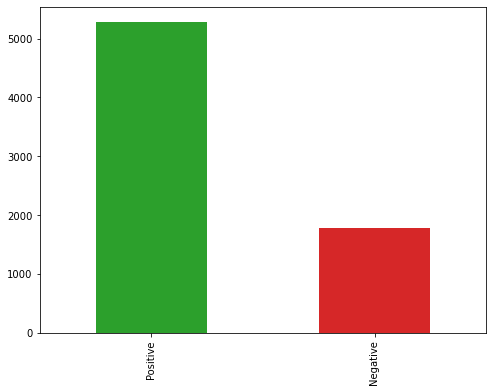

In [5]:
# How many Positive vs. Negative?
print(df['sentiment'].value_counts())
df['sentiment'].value_counts().plot(kind='bar', color=['tab:green', 'tab:red'], figsize=(8, 6))

This is a skewed dataset with many more *positive* reviews than there are *negative* reviews. This is something to bear in mind throughout the analysis.

Before proceeding, I also split the dataset into train and test sets. I check to make sure that the relative proportion between positive and negative reviews for each partition is representative of the full sample.

In [6]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=123456)
print('Training samples:', len(df_train))
print('Training Positive Ratio:', df_train['sentiment'].value_counts()['Positive'] / df_train['sentiment'].value_counts().sum(), '\n')

print('Test samples:', len(df_test))
print('Test Positive Ratio:', df_test['sentiment'].value_counts()['Positive'] / df_test['sentiment'].value_counts().sum(), '\n')

Training samples: 5644
Training Positive Ratio: 0.7475194897236003 

Test samples: 1412
Test Positive Ratio: 0.7485835694050992 



## Part (a) and Part (b)

Perform basic tokenization and normalization on the product reviews. At a minimum, you should:

- standardize the word case (i.e. upper or lower case);
- remove punctuation and common stop words; and
- perform *some* stemming or lemmatization to reduce the number of unique tokens.

Use the overall statistics of the corpus of reviews to guide this step. Your cleaned output should be a *list of tokens representing each review*.

Let the set of all unique terms (i.e. the dictionary) be $\mathcal{T}$ , and the set of all reviews (i.e. corpus of documents) be $\mathcal{D}$. For each term $t ∈ \mathcal{T}$ and review $d ∈ \mathcal{D}$, define the term frequency–inverse document frequency (tf-idf) score

\begin{align}
\text{tf-idf}_{t,d} &= \text{tf}_{t,d} * \text{idf}_t \\
&= \left( \frac{1}{|d|} \sum_{i∈d} \mathbf{1}_{\{i=t\}} \right) * \left(\log\frac{|\mathcal{D}|}{|\{ d ∈ \mathcal{D} : t ∈ d \}|}\right),
\end{align}

where | · | denotes the size of a set, and $\mathbf{1}_{\{·\}}$ denotes the indicator function. Notice that
$\text{tf}_{t,d}$ simply counts the number of times term $t$ appears in review $d$, normalized by the number of terms in $d$, while $\text{idf}_t$ is inversely proportional to the number of reviews that $t$ appears in, scaled by the total number of reviews.

> Q) Using appropriate data structures, write an algorithm to compute the $|\mathcal{D}| * |\mathcal{T}|$ matrix of tf-idf scores $\mathbf{X}$ where

\begin{equation}
X_{d,t} = \text{tf-idf}_{t,d}.
\end{equation}

You may restrict your dictionary to only terms that occur at least a certain number of times throughout the corpus, bearing in mind any impact on your work in part(c).

> Q) Assuming that hashing takes constant time and defining any additional notation where necessary, derive the big-$\mathcal{O}$ time and space complexity of your solution.

### Code Implementation

#### Lemmatization and Basic Preprocessing

Briefly, the steps implemented in the `tokenizer()` function are as follows:

1. Take in an array of all the reviews
2. Tokenize and lemmatize each sentence
3. Clean the text - punctuation, numbers, and standardise lower case
4. Remove words that are less than two characters long

In [7]:
def tokenizer(text_array):
    nlp = English()
    tokenizer = nlp.Defaults.create_tokenizer(nlp)
    token_list = []
    for text in text_array:
        tokens = tokenizer(text)  # tokenize text
        lemm = [token.lemma_ for token in tokens if token.is_stop is False]
        return_list = []
        for i in range(len(lemm)):
            temp_text = re.sub('<[^>]*>', '', lemm[i])
            temp_text = re.sub(r'[0-9]+', '', lemm[i])
            temp_text = re.sub('[\W]+', '', temp_text.lower())
            if len(temp_text) > 1:
                return_list.append(temp_text)
        token_list.append(return_list)
    return token_list

tokenized_reviews= tokenizer(df_train['review'].values)

avg = 0
for i in tokenized_reviews:
    avg += len(i)
avg = avg / len(tokenized_reviews)
print('Average tokens per sentence:', round(avg))

Average tokens per sentence: 20


#### Compute tf-idf scores

In [8]:
def tfidfvectorizer(tokenized_reviews, dict_size=500):
    
    wordfreq, word_idf_values, word_tf_values = {}, {}, {}
    tfidf_scores = []
    
    # First, get the overall word frequencies of each word
    for sent in tokenized_reviews:
        
        for token in sent:
            if token not in wordfreq.keys():
                wordfreq[token] = 1
            else:
                wordfreq[token] += 1
    
    # Keep the words that occur at least 500 times (default)
    most_freq = heapq.nlargest(dict_size, wordfreq, key=wordfreq.get)
    
    for token in most_freq:
        reviews_containing_word = 0
        sent_tf_vector = []
        
        for sent in tokenized_reviews:
            doc_freq = 0
            if token in sent:
                reviews_containing_word += 1
            for word in sent:
                if word == token:
                    doc_freq += 1
            word_tf = doc_freq / len(tokenized_reviews)
            sent_tf_vector.append(word_tf)
        
        #'term-frequency'
        word_tf_values[token] = sent_tf_vector
        
        # inverse-docyument-frequency
        word_idf_values[token] = np.log(len(tokenized_reviews) / (1 + reviews_containing_word)) 
    
    for token in word_tf_values.keys():
        
        tfidf_sentences = []
        
        for tf_sentence in word_tf_values[token]:
            tf_idf_score = tf_sentence * word_idf_values[token]
            tfidf_sentences.append(tf_idf_score)
            
        tfidf_scores.append(tfidf_sentences)
    
    return np.asarray(tfidf_scores).T

If the function above is correct, we expect to see a result with dimensions *length of training set x dictionary size (500)*:

In [9]:
X = tfidfvectorizer(tokenized_reviews)
X.shape

(5644, 500)

#### Big-O Time and Space Complexity

In [11]:
import time

start = time.time()
X = tfidfvectorizer(tokenized_reviews[:1000])
print('100:', time.time() - start)

start=time.time()
X = tfidfvectorizer(tokenized_reviews[:2000])
print('200:', time.time() - start)

start=time.time()
X = tfidfvectorizer(tokenized_reviews[:3000])
print('300:', time.time() - start)

start=time.time()
X = tfidfvectorizer(tokenized_reviews[:4000])
print('400:', time.time() - start)

100: 0.4629499912261963
200: 0.9171183109283447
300: 1.3614447116851807
400: 1.8320987224578857


Assuming that hashing takes constant time,

\begin{equation}
    \text{Big}-\mathcal{O}\text{ complexity} = \mathcal{O}(n)\\
    \text{Space Complexity} = \mathcal{O}(n)
\end{equation}



## Part (c)

Fit a classifier of your choice to predict review sentiment using the feature matrix $X$.

i) Perform any necessary pre-processing to ensure reliable model fitting and evaluation.

ii) Also perform hyperparameter tuning for at least one hyperparameter that is important to model performance.

iii) Document and briefly discuss any findings and challenges, linking them to potential
business questions that your predictions might be used for.

### Code Implementation

I will be using a Support Vector Classifier. Though the fit time scales quadratically with the number of samples, this is a relatively small dataset.

In [13]:
# Preprocess data as described in previous sections
X_train = df_train['review'].values
X_train_tokenized = tokenizer(X_train)
X_train_processed = tfidfvectorizer(X_train_tokenized)

y_train = df_train['sentiment'].values

In [19]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define parameter grid for gridsearch
param_grid = {
    'C': [1, 0.1, 0.01, 0.001],
    'gamma': ['scale', 'auto']}

search = GridSearchCV(SVC(), param_grid=param_grid)
search.fit(X_train_processed, y_train)
print('Best parameters:')
search.best_params_

Best parameters:


{'C': 1, 'gamma': 'scale'}

In [20]:
model = SVC(C=1, gamma='scale', kernel='linear')
model.fit(X_train_processed, y_train)
print('Train accuracy:', model.score(X_train_processed, y_train))

Train accuracy: 0.7475194897236003


Now I use the model to make predictions on the test set:

In [21]:
X_test = df_test['review'].values
X_test_tokenized = tokenizer(X_test)
X_test_processed = tfidfvectorizer(X_test_tokenized)

y_test = df_test['sentiment'].values

y_predict = model.predict(X_test_processed)

In [22]:
np.sum(y_test == y_predict) / len(y_test)

0.7485835694050992